In [68]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

In [70]:
def accuracy(model, val, train=False):
    if train:
        model.train()
    else:
        model.eval()

    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [71]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [72]:
def get(x):
    # return train.dataset[x][0].view(1, 784)
    # z = [1]
    # z.append(train.dataset[x][0])
    # z = torch.tensor(z)
    # print(train.dataset[x][0].size())

    return torch.reshape(train.dataset[x][0], (1, 1, 28, 28))

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(-3, 3, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

## <font color='orange'> MNIST </font> 

In [73]:
model = nn.Sequential(
    nn.Linear(28*28, 392),
    nn.ReLU(),

    nn.Linear(392, 28),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(28, 10),
    nn.LogSoftmax(dim=1),
)

0.9178833333333334 0.9477
0.9096 0.9723
0.9114666666666666 0.9754
0.9098 0.9778
0.9104833333333333 0.9805
0.8881 0.9769
0.89105 0.9781
0.8965166666666666 0.9806
0.8997666666666667 0.9828
0.8937833333333334 0.9816
0.8968666666666667 0.9832
0.8975166666666666 0.9844
0.8967333333333334 0.9841
0.8933 0.984
0.8903 0.9833
0.8912333333333333 0.9846
0.8901 0.9842
0.8893833333333333 0.9846
0.8885333333333333 0.9843
0.88845 0.9841


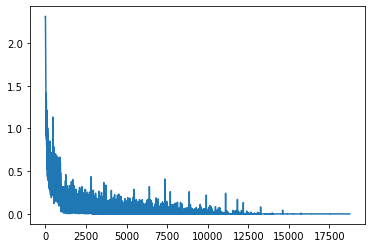

In [74]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 
optimizer = torch.optim.Adadelta(model.parameters()) 
criterion = nn.NLLLoss()

train_losses = []
for epoch in range(20):
    for X, y in train:
        X = X.view(-1, 784) 
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        
        optimizer.step()
    
    print(accuracy(model, train, True), accuracy(model, val, False))
        
plt.plot(train_losses)
plt.show()

## <font color='orange'> Autoencoder 

In [75]:
from torch.nn.modules.batchnorm import BatchNorm3d
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.pooling import MaxPool2d
from numpy.core.fromnumeric import reshape


In [103]:
class Autoencoder(nn.Module):
    def __init__(self, h=16):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(1, 1, 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(1, 1, 4), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(start_dim=1), 

            nn.Linear(16, 16),  
            nn.ReLU(),

            nn.Linear(16, h),  
            nn.ReLU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(h, 10),  
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, 100),
            nn.ReLU(),

            nn.Linear(100, 28*28),
            nn.ReLU(),
        )
    
    def forward(self, x):
      encoded = self.encode(x)
      return self.decode(encoded)


### GIF

In [77]:
model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        data = data.view(-1, 784)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0684
epoch 1, loss 0.0498
epoch 2, loss 0.0436
epoch 3, loss 0.0408
epoch 4, loss 0.0392
epoch 5, loss 0.0383
epoch 6, loss 0.0374
epoch 7, loss 0.0363
epoch 8, loss 0.0356
epoch 9, loss 0.0346
epoch 10, loss 0.0339
epoch 11, loss 0.0333
epoch 12, loss 0.0329
epoch 13, loss 0.0324
epoch 14, loss 0.0319
epoch 15, loss 0.0317
epoch 16, loss 0.0316
epoch 17, loss 0.0314
epoch 18, loss 0.0313
epoch 19, loss 0.0312


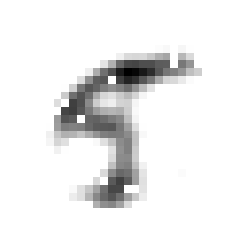

In [78]:
morph(np.random.randint(0, len(train.dataset), 30), 20, 35)

### Pic

In [79]:
from matplotlib import colors as mcolors

colors = list(mcolors.CSS4_COLORS.values())
colors = list(mcolors.BASE_COLORS)
colors = list(mcolors.TABLEAU_COLORS)

In [106]:
model = Autoencoder(h=2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(20):
    train_loss = 0
    for data, _ in train:        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        data = data.view(-1, 784)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0764
epoch 1, loss 0.0660
epoch 2, loss 0.0635
epoch 3, loss 0.0614
epoch 4, loss 0.0600
epoch 5, loss 0.0591
epoch 6, loss 0.0587
epoch 7, loss 0.0580
epoch 8, loss 0.0570
epoch 9, loss 0.0567
epoch 10, loss 0.0565
epoch 11, loss 0.0564
epoch 12, loss 0.0563
epoch 13, loss 0.0562
epoch 14, loss 0.0561
epoch 15, loss 0.0560
epoch 16, loss 0.0558
epoch 17, loss 0.0556
epoch 18, loss 0.0555
epoch 19, loss 0.0552


In [109]:
points = [[] for i in range(10)]
for batch in train:
  # print(batch)
  xs, l = batch
  labeled = zip(xs, l)
  for x, label in labeled:
    points[label] += [model.encode(torch.reshape(x, [1, 1, 28, 28])).detach().numpy()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


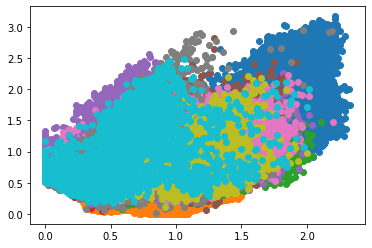

In [110]:
points = np.array(points)
for i, p in enumerate(points):
  p = np.array(p)
  # print(p)
  p = np.reshape(p, (int(p.flatten().size/2), 2))
  # print(np.reshape(p, (int(p.flatten().size/2), 2)))
  xs, ys = zip(*p)
  # print(xs, ys) 
  plt.scatter(xs,ys, color=colors[i])
  # break